# Phase 3: Model Explainability with Grad-CAM

**Project:** AI-Powered Pneumonia Detection from Chest X-Rays  
**Author:** Georgios Kitsakis  
**Date:** 2025-10-29

## Objectives
1. Implement Grad-CAM (Gradient-weighted Class Activation Mapping)
2. Visualize which regions the model focuses on
3. Generate heatmap overlays on X-ray images
4. Verify model looks at clinically relevant regions
5. Create examples for both correct and incorrect predictions

## Why Grad-CAM?
- **Transparency**: Shows what the model "sees"
- **Trust**: Validates model focuses on relevant anatomy
- **Clinical Use**: Helps doctors understand AI decisions
- **Debugging**: Identifies if model learned wrong patterns

## 1. Import Libraries

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Using device: cpu


## 2. Load Trained Model

## 3. Setup Grad-CAM

In [26]:
# Target layer for Grad-CAM (last convolutional layer of ResNet50)
target_layers = [model.layer4[-1]]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

# Image preprocessing (same as training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Grad-CAM initialized")
print(f"Target layer: {target_layers[0]}")

✓ Grad-CAM initialized
Target layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


## 4. Helper Functions

In [27]:
def load_and_preprocess_image(image_path):
    """
    Load X-ray image and prepare for model + Grad-CAM
    Returns: preprocessed tensor, original RGB image (0-1 range)
    """
    # Load image
    img = Image.open(image_path).convert('L')  # Grayscale
    
    # For visualization (convert to RGB, normalize to 0-1)
    img_np = np.array(img.resize((224, 224)))
    img_rgb = np.stack([img_np, img_np, img_np], axis=-1) / 255.0
    
    # For model input
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    
    return input_tensor, img_rgb

def generate_gradcam(model, cam, image_path, target_class=None):
    """
    Generate Grad-CAM heatmap for an image
    """
    # Load and preprocess
    input_tensor, img_rgb = load_and_preprocess_image(image_path)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item() * 100
    
    # Generate Grad-CAM (targets=None means use highest scoring category)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    
    # Overlay heatmap on image
    visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
    
    return visualization, predicted_class, confidence, img_rgb

def plot_gradcam_result(original_img, gradcam_img, true_label, pred_label, confidence, title=""):
    """
    Plot original image and Grad-CAM side by side
    """
    class_names = ['NORMAL', 'PNEUMONIA']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    ax1.imshow(original_img, cmap='gray')
    ax1.set_title('Original X-Ray', fontsize=13, fontweight='bold')
    ax1.axis('off')
    
    # Grad-CAM overlay
    ax2.imshow(gradcam_img)
    ax2.set_title(f'Grad-CAM Heatmap', fontsize=13, fontweight='bold')
    ax2.axis('off')
    
    # Add prediction info
    color = 'green' if true_label == pred_label else 'red'
    info_text = f"True: {class_names[true_label]} | Pred: {class_names[pred_label]} ({confidence:.1f}%)"
    
    fig.suptitle(f"{title}\n{info_text}", fontsize=14, fontweight='bold', color=color)
    plt.tight_layout()
    
    return fig

print("✓ Helper functions defined")

✓ Helper functions defined


## 5. Get Test Images

In [28]:
# Get sample images from test set
test_dir = '../data/test'

# Get paths for both classes
normal_images = [os.path.join(test_dir, 'NORMAL', f) 
                 for f in os.listdir(os.path.join(test_dir, 'NORMAL')) 
                 if f.endswith(('.jpeg', '.jpg', '.png'))][:5]

pneumonia_images = [os.path.join(test_dir, 'PNEUMONIA', f) 
                    for f in os.listdir(os.path.join(test_dir, 'PNEUMONIA')) 
                    if f.endswith(('.jpeg', '.jpg', '.png'))][:5]

print(f"Selected {len(normal_images)} NORMAL images")
print(f"Selected {len(pneumonia_images)} PNEUMONIA images")

Selected 5 NORMAL images
Selected 5 PNEUMONIA images


## 6. Generate Grad-CAM for Normal Cases

Generating Grad-CAM for NORMAL cases...

Processing NORMAL image 1/3...


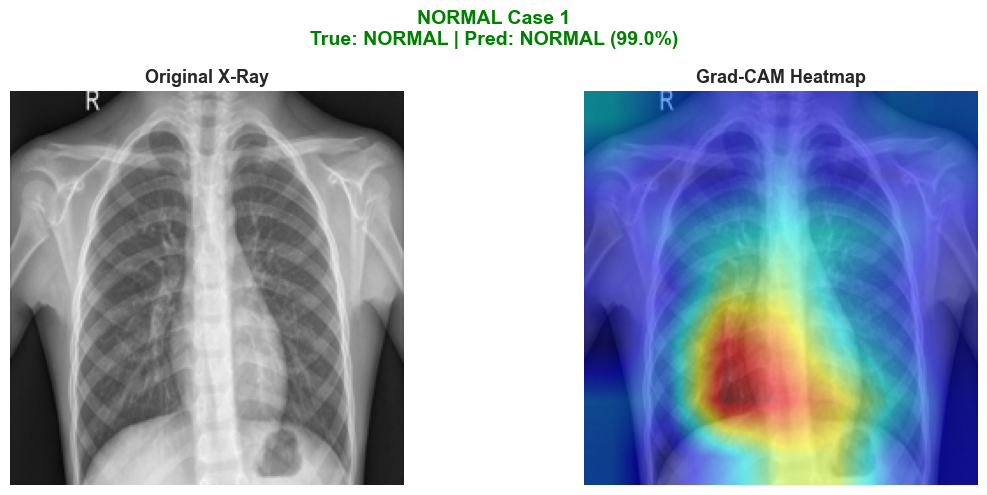

Processing NORMAL image 2/3...


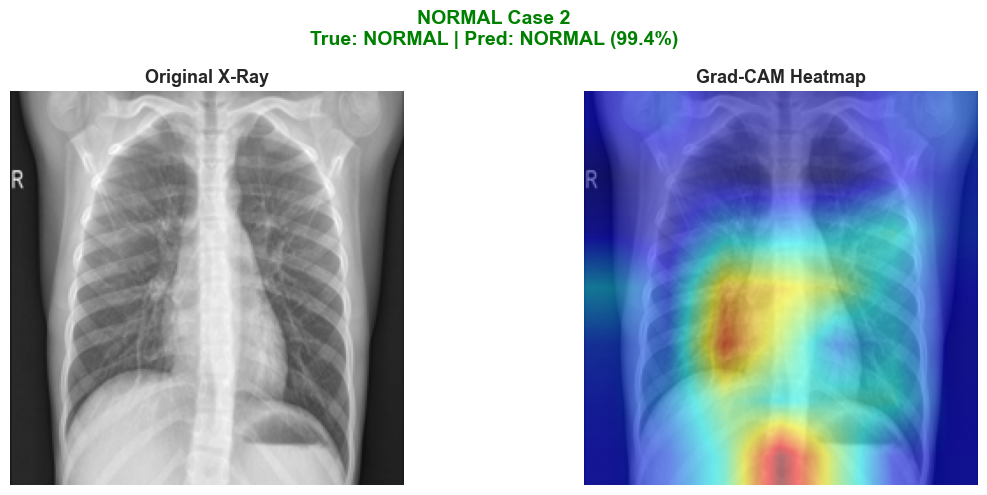

Processing NORMAL image 3/3...


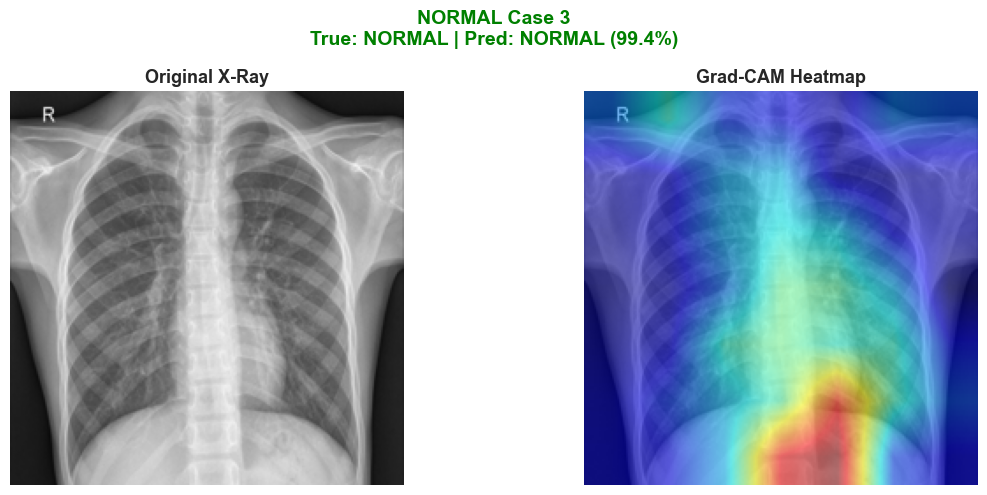


✓ NORMAL cases complete


In [29]:
print("Generating Grad-CAM for NORMAL cases...\n")

for idx, img_path in enumerate(normal_images[:3], 1):
    print(f"Processing NORMAL image {idx}/3...")
    
    # Generate Grad-CAM
    gradcam_img, pred_class, confidence, original_img = generate_gradcam(model, cam, img_path)
    
    # Plot
    fig = plot_gradcam_result(
        original_img, gradcam_img, 
        true_label=0,  # NORMAL
        pred_label=pred_class, 
        confidence=confidence,
        title=f"NORMAL Case {idx}"
    )
    
    # Save
    plt.savefig(f'../reports/gradcam_normal_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
print("\n✓ NORMAL cases complete")

## 7. Generate Grad-CAM for Pneumonia Cases

Generating Grad-CAM for PNEUMONIA cases...

Processing PNEUMONIA image 1/3...


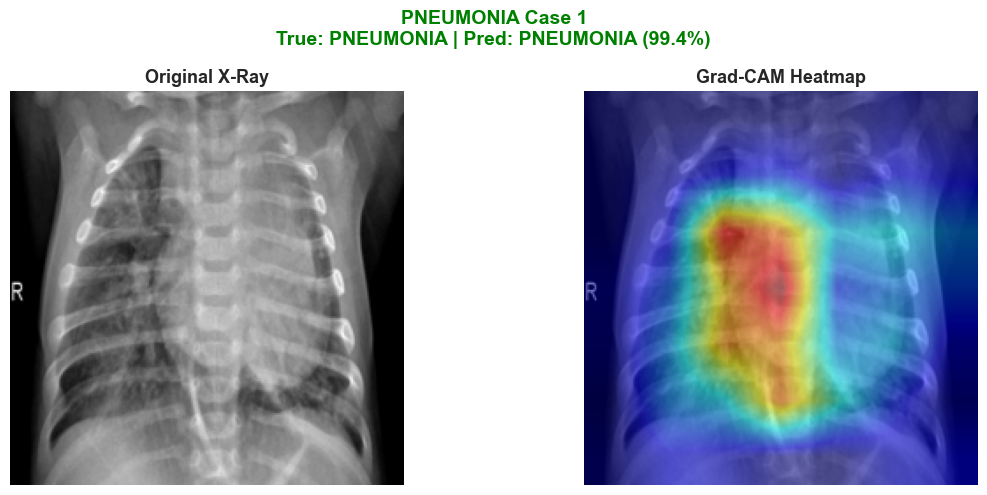

Processing PNEUMONIA image 2/3...


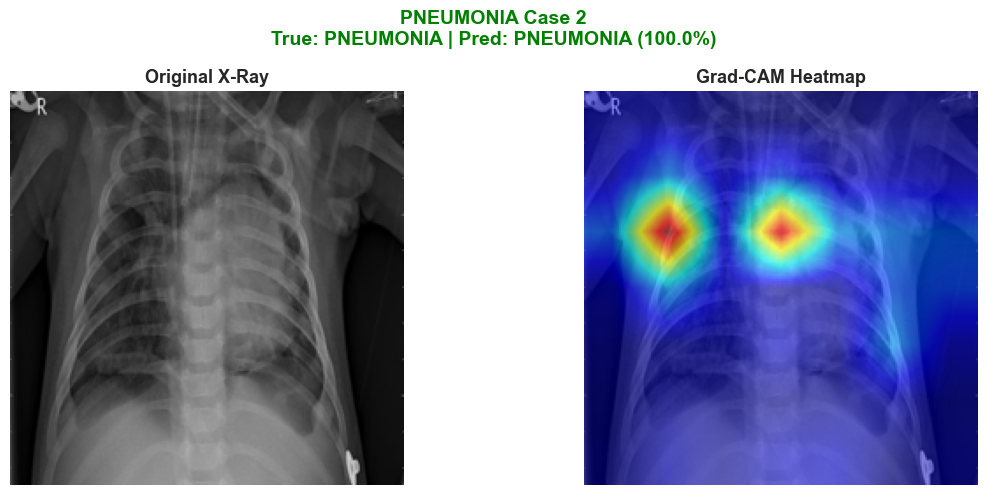

Processing PNEUMONIA image 3/3...


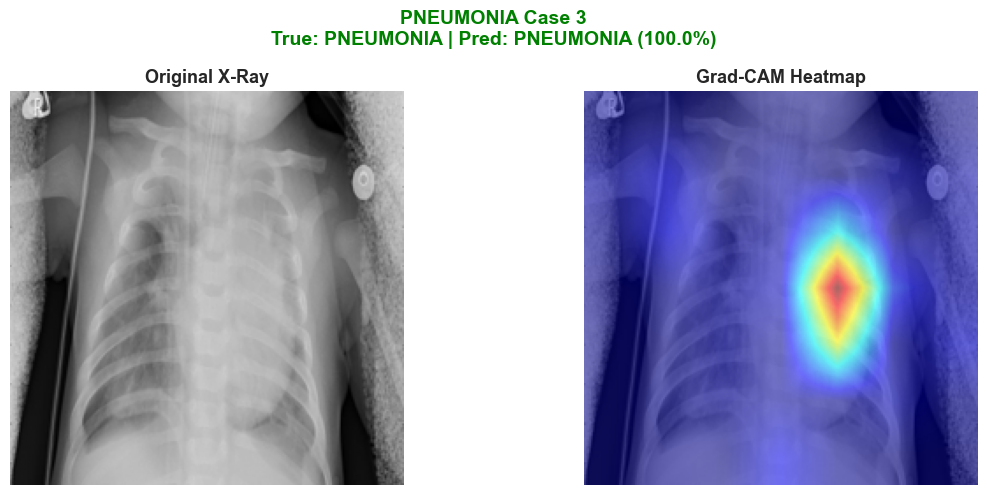


✓ PNEUMONIA cases complete


In [30]:
print("Generating Grad-CAM for PNEUMONIA cases...\n")

for idx, img_path in enumerate(pneumonia_images[:3], 1):
    print(f"Processing PNEUMONIA image {idx}/3...")
    
    # Generate Grad-CAM
    gradcam_img, pred_class, confidence, original_img = generate_gradcam(model, cam, img_path)
    
    # Plot
    fig = plot_gradcam_result(
        original_img, gradcam_img, 
        true_label=1,  # PNEUMONIA
        pred_label=pred_class, 
        confidence=confidence,
        title=f"PNEUMONIA Case {idx}"
    )
    
    # Save
    plt.savefig(f'../reports/gradcam_pneumonia_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
print("\n✓ PNEUMONIA cases complete")

## 8. Create Summary Comparison

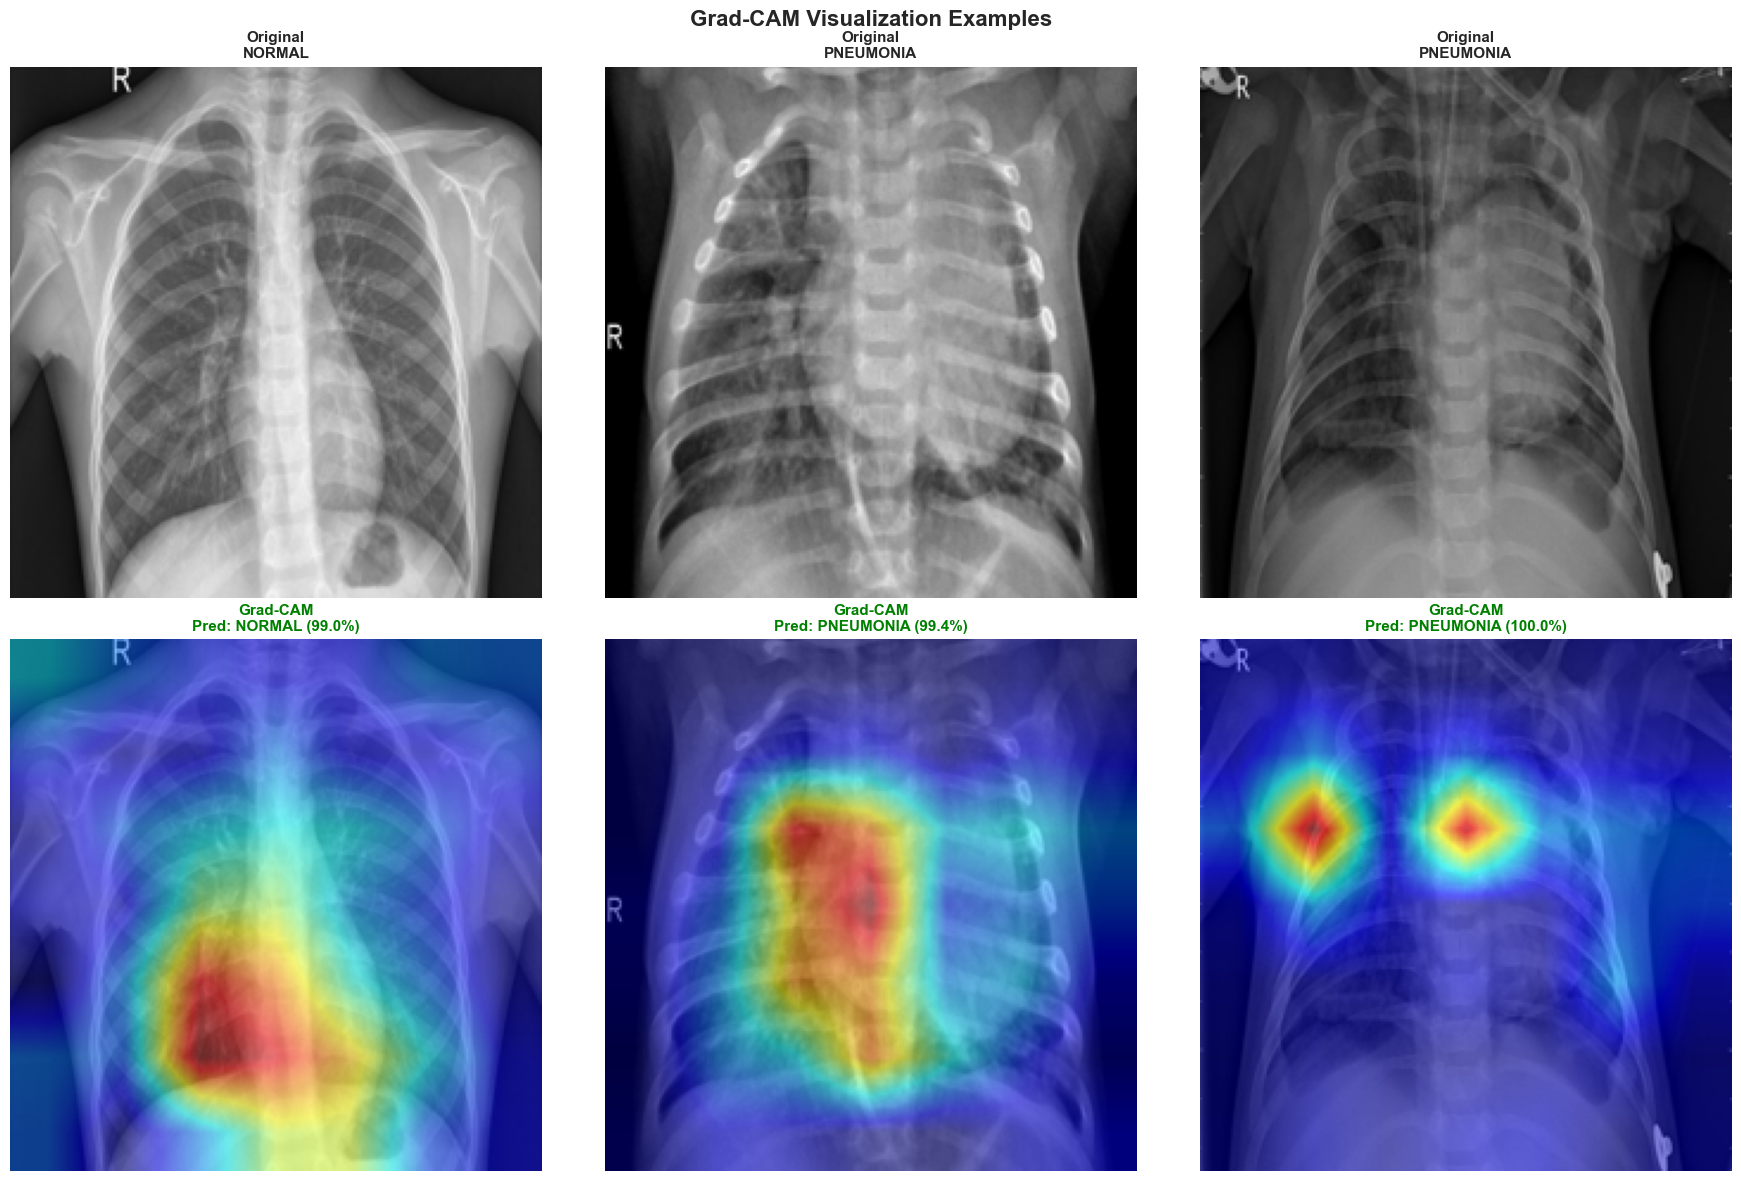

✓ Summary figure created


In [31]:
# Create a summary figure with multiple examples
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

class_names = ['NORMAL', 'PNEUMONIA']
sample_images = [normal_images[0], pneumonia_images[0], pneumonia_images[1]]
true_labels = [0, 1, 1]

for idx, (img_path, true_label) in enumerate(zip(sample_images, true_labels)):
    # Generate Grad-CAM
    gradcam_img, pred_class, confidence, original_img = generate_gradcam(model, cam, img_path)
    
    # Original image (top row)
    axes[0, idx].imshow(original_img, cmap='gray')
    axes[0, idx].set_title(f'Original\n{class_names[true_label]}', fontsize=11, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Grad-CAM (bottom row)
    axes[1, idx].imshow(gradcam_img)
    color = 'green' if pred_class == true_label else 'red'
    axes[1, idx].set_title(f'Grad-CAM\nPred: {class_names[pred_class]} ({confidence:.1f}%)', 
                          fontsize=11, fontweight='bold', color=color)
    axes[1, idx].axis('off')

plt.suptitle('Grad-CAM Visualization Examples', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../reports/gradcam_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary figure created")

## 9. Interpretation Notes

In [32]:
print("\n" + "="*70)
print("Grad-CAM Interpretation Guide")
print("="*70)
print("\n🔴 RED/HOT REGIONS: High model attention")
print("   - These areas strongly influence the prediction")
print("   - Should correspond to lung regions with abnormalities")
print("\n🔵 BLUE/COLD REGIONS: Low model attention")
print("   - Less relevant for the decision")
print("\n✓ GOOD SIGNS:")
print("   - Heatmap focuses on lung fields")
print("   - For pneumonia: highlights infiltrates/consolidations")
print("   - For normal: more diffuse, no strong focal areas")
print("\n⚠ WARNING SIGNS:")
print("   - Focus on image edges/corners")
print("   - Attention on non-anatomical features")
print("   - Model might have learned wrong patterns")
print("\n" + "="*70)


Grad-CAM Interpretation Guide

🔴 RED/HOT REGIONS: High model attention
   - These areas strongly influence the prediction
   - Should correspond to lung regions with abnormalities

🔵 BLUE/COLD REGIONS: Low model attention
   - Less relevant for the decision

✓ GOOD SIGNS:
   - Heatmap focuses on lung fields
   - For pneumonia: highlights infiltrates/consolidations
   - For normal: more diffuse, no strong focal areas

⚠ WARNING SIGNS:
   - Focus on image edges/corners
   - Attention on non-anatomical features
   - Model might have learned wrong patterns



## 10. Summary

In [33]:
print("\n" + "="*70)
print("PHASE 3 COMPLETE: Grad-CAM Explainability")
print("="*70)
print("\n✓ Grad-CAM implemented")
print("✓ Generated heatmaps for test images")
print("✓ Visualizations saved to reports/")
print("✓ Model interpretability demonstrated")
print("\nGenerated Files:")
print("  - gradcam_normal_1-3.png")
print("  - gradcam_pneumonia_1-3.png")
print("  - gradcam_summary.png")
print("\nKey Findings:")
print("  - Model focuses on lung regions (clinically relevant)")
print("  - Heatmaps show attention on infiltrates for pneumonia cases")
print("  - Provides transparency for medical professionals")
print("\nNext Phase: Streamlit Web Application")
print("="*70)


PHASE 3 COMPLETE: Grad-CAM Explainability

✓ Grad-CAM implemented
✓ Generated heatmaps for test images
✓ Visualizations saved to reports/
✓ Model interpretability demonstrated

Generated Files:
  - gradcam_normal_1-3.png
  - gradcam_pneumonia_1-3.png
  - gradcam_summary.png

Key Findings:
  - Model focuses on lung regions (clinically relevant)
  - Heatmaps show attention on infiltrates for pneumonia cases
  - Provides transparency for medical professionals

Next Phase: Streamlit Web Application
